# 1) Simulation de données
### Simulation des observations de variables fonctionnelles

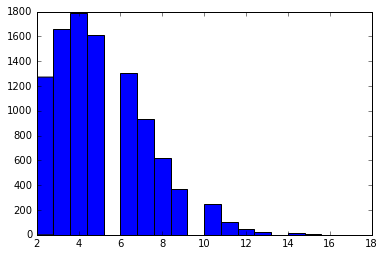

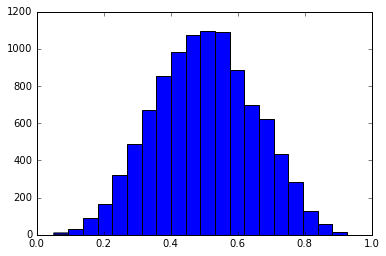

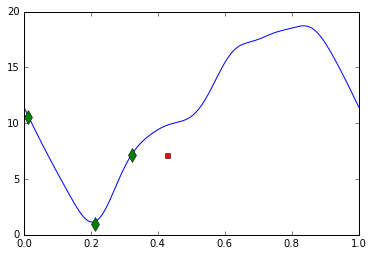

In [9]:
from Classes import * 
from Simu import *
from NLL import *
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
from scipy import integrate
import sympy as sy
from scipy import linalg
import pylab as pl
import math as ma
import time 
%matplotlib inline



N=1000
D=1
n_t_moy=10
varu=5
Gamma=0.1
# Simulation des temps 
(T,L,M_nt)=temps(N,D,n_t_moy)
(U,V1,V2)=X_Params(varu,N,D)
vec=np.reshape(M_nt,(N*D,1))

fig1 = plt.figure().add_subplot(111)
fig1.hist(vec,bins=20)
fig2 = plt.figure().add_subplot(111)
fig2.hist(T,bins=20)


# Exemple de signe vital simulé
t=np.linspace(0,1,1000)
X=X_fonc(t,U[0,0],V1[0,0,:],V2[0,0,:])

fig2 = plt.figure().add_subplot(111)
fig2.plot(t,X.val())


#plt.savefig("Ftraj.png")
Xdata=X_obs(U,V1,V2,L,std=Gamma)
fig2.plot(L[0][0],Xdata[0][0],marker="d",markersize=10,linestyle="none")
fig2.plot(T[0],Xdata[0][0][len(Xdata[0][0])-1],marker="s",markersize=5,color="r")
#plt.savefig("Xobs.png")

### Simulation des labels $Y$, $C$ et $Y^C$

Moyenne et écart type des labels non censurés Y
1.3250757
5.5661890521
Pourcentage de données non censurées
80.0


(array([ 2.,  0.,  0.,  1.,  0.,  1.,  1.,  2.,  1.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ -5.95514636,  -4.92041384,  -3.88568132,  -2.8509488 ,
         -1.81621628,  -0.78148375,   0.25324877,   1.28798129,
          2.32271381,   3.35744633,   4.39217885,   5.42691137,
          6.46164389,   7.49637641,   8.53110893,   9.56584145,
         10.60057397,  11.63530649,  12.67003902,  13.70477154,  14.73950406]),
 <a list of 20 Patch objects>)

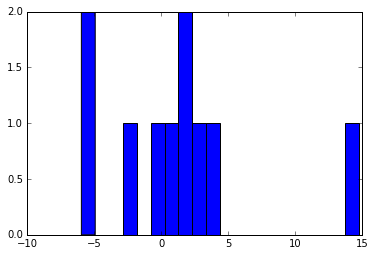

In [25]:
%matplotlib inline

Sigma=0.

true_beta=beta(num=1)

# Nombre de variables scalaires
p=1
# Génération de Alpha et Z
Alpha=np.zeros(p,float)
Z=np.zeros((N,p),float)
(Y,C,Yc,Delta)=simu_YC(Alpha,true_beta,Z,U,V1,V2,T,Sigma)
print("Moyenne et écart type des labels non censurés Y")
print( np.mean(Y))
print(np.std(Y))

print( "Pourcentage de données non censurées")
print(100.*np.sum(Delta)/N)

fig1 = plt.figure().add_subplot(111)
fig1.hist(Y,bins=20)


# 1) Régression GP sur Python pour l'inférence des variables GP

Nous allons commencer par l'utilisation la plus basique du package pyGPs qui est similaire à l'application que nous avons faîte des Gaussians Process sur R, à savoir la régression sur processus gaussien avec l'hypothèse d'un noyau exponentiel quadratique et d'une moyenne nulle. Cette utilisation nous est suffisante pour obtenir les estimateurs des paramètres de covariance (la variance et la portée de la fonction de covariance, ainsi que l'erreur résiduelle du modèle) que nous utiliserons dans un deuxième temps comme variables GP de la régression sur les logarithmes des temps de survie. 

## A) Un premier exemple tiré du package

On utilise le modèle de Régression sur Processus Gaussien :

$y_i = f(t_i) + \epsilon_i$ où les $\epsilon_i$ sont des erreurs gaussiennes $\mathcal{N}(0,sig)$ iid.

et $f\sim \mathcal{GP}(m,k)$.

Ce modèle de régression peut être utilisé dans le package pyGPs en utilisant la classe pyGPs.GPR(). Les options par défauts sont m=0, k=noyau exponentiel quadratique, une vraisemblance gaussienne (qui contient par défaut le bruit gaussien E_i) et une méthode d'optimisation par minimisation de la negative log vraisemblance relative aux hyperparamètres de m, k et sig.  

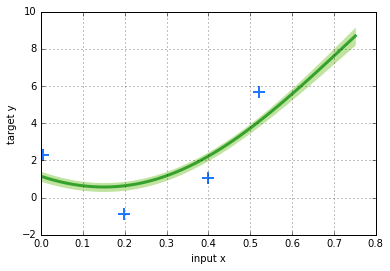

HYPERPARAMETRES AJUSTES
Moyenne empirique
2.02263901801
Moyenne estimée GP
5.0
Hyperparamètres de la fonction de covariance estimés
[ 1.          1.          2.71828183  2.71828183  1.        ]
Ecart type de l erreur gaussienne
0.100000509301


In [29]:
import pyGPs

# Données choisies pour l'exemple
idv=1
par=0

x=np.asarray(L[idv][par])
y=np.asarray(Xdata[idv][par])
z=np.linspace(0,T[idv],50)

moy=np.mean(y)

model = pyGPs.GPR()  # GP regression
# Spécification du modèle (Celles ci sont facultatives car elles correspondent aux paramètres par défaut de pyGPs.GPR)
# On définit la forme et les paramètres initiaux de la fonction de covariance du prior GP 
k1=pyGPs.cov.RBF(log_ell=0.0, log_sigma=0.0) 
k2=pyGPs.cov.Periodic(log_ell=0., log_p=0., log_sigma=0.)
k=pyGPs.cov.SumOfKernel(k1,k2)
# Evaluation d'un scalaire par la fonction
# Evaluation d'un array
m=pyGPs.mean.Const() # Fonction moyenne du GP (Ici constante nulle)
model.setPrior(mean=m,kernel=k) 
model.setNoise(log_sigma=-2.30258)# On peut aussi donner une valeur initiale pour la variance de l'erreur (0.1 ici)

# Inférence 
model.getPosterior(x, y) # fit default model (mean zero & rbf kernel) with data
#model.optimize(x, y)     # optimize hyperparamters (default optimizer: single run minimize of gaussian likelihood)
model.predict(z)         # predict test cases
model.plot()             # and plot result

# Extraction des hyperparamètres optimisés
print('HYPERPARAMETRES AJUSTES')
print('Moyenne empirique')
print(moy)
print('Moyenne estimée GP')
print(model.meanfunc.hyp[0])
print('Hyperparamètres de la fonction de covariance estimés')
print(np.exp(model.covfunc.hyp))
print('Ecart type de l erreur gaussienne')
print(np.exp(model.likfunc.hyp)[0])
# Voir la page détaillant les entrées des fonctions pour plus de détails sur les hyperparamètres avec d'autres modèles
# http://www-ai.cs.uni-dortmund.de/weblab/static/api_docs/pyGPs/Default.html


## B) Estimation des paramètres GP sur les données simulées 

In [63]:
model = pyGPs.GPR()
k1=pyGPs.cov.RBF(log_ell=0.0, log_sigma=0.0) 
k2=pyGPs.cov.Periodic(log_ell=0., log_p=0., log_sigma=0.)
k=pyGPs.cov.SumOfKernel(k1,k2)
m=pyGPs.mean.Const() 
model.setPrior(mean=m,kernel=k) 
model.setNoise(log_sigma=-2.30258)

par_est=np.zeros((N,D,len(model.covfunc.hyp)+1),float)
moy_est=np.zeros((N,D),float)

tps1 = time.clock()
for i in range(N):
    for j in range(D):
        # On effectue la régression sur processus gaussien pour chaque jeu de données et on stocke les paramètres estimés
        y=np.asarray(Xdata[i][j])
        x=np.asarray(L[i][j])
        model.optimize(x, y)
        moy_est[i,j]=model.meanfunc.hyp[0]
        par_est[i,j,:]=np.concatenate(  (np.array(np.exp(model.covfunc.hyp)), np.array(np.exp(model.likfunc.hyp))), axis=0 )
tps2 = time.clock()

nobs_moy=np.mean(M_nt)
print("temps écoulé pour ajuster ", N*D ," courbes avec en moyenne " , nobs_moy, " points :")
print(tps2 - tps1)

('temps \xc3\xa9coul\xc3\xa9 pour ajuster ', 10, ' courbes avec en moyenne ', 9.5, ' points :')
1.06591956675


## C) Calcul de la vraisemblance de Y conditionnellement à X et aux paramètres estimés

Suite à une simulation de différentes séries temporelles, nous avons ajusté des paramètres associées à chacune d'entre elle selon un modèle de Régression sur Processus Gaussien. A présent, nous simulons les labels $Y_i$ selon le modèle VDFR en utilisant la trajectoire réelle des variables fonctionnelles. Puis, nous tentons d'évaluer la vraisemblance des labels $Y_i$ conditionellement aux $X^i_j$ et aux paramètres $\gamma^i_j,\theta^i_j,\eta^i_j$ appris avec la modélisation des variables fonctionnelles par des processus gaussien.

In [64]:

# Calcul des matrices de covariances et inverses Psi pour chaque courbe grâce aux paramètres estimés
N=len(L)
D=len(L[0])
n_par=len(par_est[0,0,:])-1
Psi=[[ [] for j in range(D)] for i in range(N)]
syk=[[ [] for j in range(D)] for i in range(N)]
k_foncs=[[ [] for j in range(D)] for i in range(N)]

t=sy.Symbol('t')
s=sy.Symbol('s')
for i in range(N):
    for j in range(D):
        m_ij=len(L[i][j])
        par=par_est[i,j,:]
        # On reconstruit le noyau k_ij (en mode perso et en sympy) à partir des paramètres estimés précédemment
        kPerio= sy_Periodic(symb=(s,t),el= par[3],per=par[4],sig=par[5]) 
        kRBF= sy_RBF(symb=(s,t), el=par[1],sig=par[2])
        syk[i][j]= kPerio + kRBF
        k_foncs[i][j]= sy.lambdify((t,s),syk[i][j],'numpy')
        K=  cov(k_foncs[i][j] , L[i][j] )
        Psi[i][j]=linalg.inv(K+par[0]*np.eye(m_ij))
print('Exemple : Premier noyau')
sy.pprint(syk[0][0])


Exemple : Premier noyau
                                                     2                        
                                              2   sin (0.776773173518751⋅s - 0
                   - 0.385090888173141⋅(s - t)  - ────────────────────────────
                                                                         2    
0.012625580511706⋅ℯ                                                           

                                                                   
.776773173518751⋅t)                                                
───────────────────                                               2
                                        -0.272426349839775⋅(s - t) 
                    + 0.85746592419675⋅ℯ                           


# 3) Test du critère $\mathcal{L}(Y|X,\mathcal{P})$ et Optimisation
## A) sur un cas de régression linéaire simple

In [98]:

# On annule les observations de variables fonctionnelles ainsi que les moyennes estimées de manière
# à annuler les intégrales dans la vraisemblance et le gradient.
for i in range(N):
    for j in range(D):
        Xdata[i][j]=np.zeros(len(L[i][j]))
        moy_est[i,j]=0.
# On génère des labels Y autour d'une moyenne fixée
Y=np.random.normal(100.,5.,N)
print('Y')
print(Y)
Kbeta=3

J=200

p=1

Z=1.*np.ones((N,p),float)
#np.random.normal(0.,10.,N*p).reshape((N,p))

# Phi_mat
Phi= Base([Kbeta,Kbeta])
Phi_mat= Comp_Phi(Phi,T,J)
print(Phi_mat.shape)
# Init de b
b=np.zeros((Kbeta**2,D),float)
# Init de Alpha
Alpha=np.zeros(p,float)

Po=np.concatenate( ( Alpha.reshape(-1), (b.T).reshape(-1)) )
print(L_YlX_noC(Po,Z,L,T,Xdata,Y,Phi_mat,k,Psi,moy_est)[0])
print(L_YlX_noC(Po,Z,L,T,Xdata,Y,Phi_mat,k,Psi,moy_est)[1])

print('vraisemblance de la vrai moyenne')

Po=np.concatenate( ( Alphaf.reshape(-1), (b.T).reshape(-1)) )
print(L_YlX_noC(Po,Z,L,T,Xdata,Y,Phi_mat,k,Psi,moy_est)[0])
print(L_YlX_noC(Po,Z,L,T,Xdata,Y,Phi_mat,k,Psi,moy_est)[1])



Y
[ 100.52729458  109.39008574   97.07736331   98.35783495  105.70375599
  102.58784884  101.02343471   95.38905217  103.20171238  100.81457579]
(2010, 9)
102986.734504
[-2028.14591694     0.             0.             0.             0.             0.
     0.             0.             0.             0.        ]
vraisemblance de la vrai moyenne


NameError: name 'Alphaf' is not defined

In [22]:
gamme=np.array([.001,.003,.01,0.03,0.1,0.3,1.])
l=len(gamme)
b=np.zeros(D*Kbeta**2,float)
Pn=np.concatenate( ( Alpha.reshape(-1),  b ) )
Pstock=np.concatenate( ( Alpha.reshape(-1),  b ) )
stock=np.zeros(l,float)

for i in range(10):
    V=L_YlX_noC(Pn,Z,L,T,Xdata,Y,Phi_mat,k,Psi,moy_est)
    print("Norme b "+str(Pn.dot(Pn))+" Vrais "+ str(V[0]))
    for j in range(l):
        Pstock[0:p]=Pn[0:p]-gamme[j]*V[1][0:p]
        stock[j]=L_YlX_noC(Pstock,Z,L,T,Xdata,Y,Phi_mat,k,Psi,moy_est)[0]        
    which_min=[ x for x in range(l) if stock[x]==np.min(stock) ][0]
    Pn[0:p]=Pn[0:p]-gamme[which_min]*V[1][0:p]

print('Paramètres finaux')
print(Pn)
print('Vrais finale')
print(V[0])
print('Grad final')
print(V[1])


Norme b 1.0 Vrais 201420.4786
Norme b 14467.6272035 Vrais 8532.11588627
Norme b 9259.64141027 Vrais 816.581377718
Norme b 10208.6521548 Vrais 507.959997376
Norme b 10015.1465493 Vrais 495.615142162
Norme b 10053.6995322 Vrais 495.121347954
Norme b 10045.9830101 Vrais 495.101596185
Norme b 10047.5260775 Vrais 495.100806115
Norme b 10047.2174545 Vrais 495.100774512
Norme b 10047.2791787 Vrais 495.100773248
Paramètres finaux
[ 100.23106721    1.            0.            0.            0.            0.
    0.            0.            0.            0.            0.        ]
Vrais finale
495.100773248
Grad final
[  2.05273247e-03  -4.75100773e+02   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00]


## B) avec une variable fonctionnelle

In [50]:
Kbeta=4
# Initialisation aléatoire de b (ne doit pas être à 0)
b= np.random.normal(0.,20.,D*Kbeta**2).reshape((Kbeta**2,D)) 
#print(b)

In [51]:
p=1
Z=np.zeros((N,p),float)
#np.random.normal(0.,10.,N*p).reshape((N,p))

Alpha=np.zeros(p,float)
Po=np.concatenate( ( Alpha.reshape(-1), (b.T).reshape(-1)) )

J=50
# Phi_mat
print("time : "+str(time.clock()))
# symbole associé au petit t (c'est à dire l'instant dans la période de suivi)
t=sy.Symbol('t')
# smbole associé au grand T (c'est à dire la durée de suivie)
s=sy.Symbol('s')

syPhi=sy.ones(Kbeta**2,1)
v=[np.arange(Kbeta),np.arange(Kbeta)]
expo=expandnp(v)
Phi_fonc=[ [] for j in range(Kbeta**2) ]
for x in range(len(expo[:,0])):
        syPhi[x]=(t**expo[x,0])*(s**expo[x,1])
        Phi_fonc[x]=sy.lambdify((t,s),syPhi[x],'numpy')  

print("Calcul de Phi_mat")
Phi_mat=Comp_Phi(Phi_fonc,T,J)
print("time : "+str(time.clock()))

V=L_YlX_noC(Po,Z,L,T,Xdata,Y,Phi_mat,k_foncs,Psi,moy_est)
print('Vrais initiale : '+str(V[0]))
print("time : "+str(time.clock()))
print('Gradient initial : '+str(V[1]))
#print('Vrais perturbée')
delta=1e-1
Pdel=Po+delta*np.ones(len(Po))
#V=L_YlX_noC(Pdel,Z,L,T,Xdata,Y,Phi_mat,k_foncs,Psi,moy_est)
#print(V[0])
#print(V[1])

time : 2835.06066896
Calcul de Phi_mat
time : 2835.16150158
Vrais initiale : 49822.3354983
time : 2835.35039706
Gradient initial : [    0.          5421.43793038   994.17453188   269.08248105    88.75793219
  2155.46466664   421.39155553   121.72986664    42.85129491   910.22894399
   190.46164625    58.78879708    22.0533396    409.20399582    91.80214581
    30.24418021    12.05091921]


### Nelder-Mead

In [14]:
# Ou avec scipy.optimize.minimize, la méthode de Nelder-Mead est une d'optimisation qui n'utilise pas le gradient
#Po=np.concatenate( ( Alpha.reshape(-1), (b.T).reshape(-1) ) )
Po=Res.x
print('Vrais initiale')
print(L_YlX_noC(Po,Z,L,T,Xdata,Y,Phi_mat,k,Psi,moy_est)[0])

opts0={'disp': True, 'ftol': 1., 'maxiter': 800}
print('Résultat par Nelder Mead')
print(time.clock())
Res=sc.optimize.minimize(L_YlX_noC_V,x0=Po, args= (Z,L,T,Xdata,Y,Phi_mat,k,Psi,moy_est) , method='Nelder-Mead',options=opts0)
print(time.clock())
b_learned=Res.x[p:(p+D*Kbeta**2)]
b_learned=(b_learned).reshape((D,Kbeta**2)).T
print(Res)
print('b_learned')
print(b_learned)


Vrais initiale
84.5483785513
Résultat par Nelder Mead
319.199131
615.639626
 final_simplex: (array([[  2.36750562,  -1.85663372,  -3.19146641,  24.59931537,
         10.61237506, -15.40163617, -56.71077704,  -7.78804533,
         20.45638313,  27.1042771 ],
       [  2.36416467,  -1.84963452,  -3.20327393,  24.56986388,
         10.58987975, -15.36463756, -56.65240806,  -7.77020055,
         20.43159102,  27.06935999],
       [  2.3649253 ,  -1.84877982,  -3.20533537,  24.56831615,
         10.58563204, -15.35618006, -56.65446682,  -7.76450834,
         20.42002621,  27.07546168],
       [  2.36362982,  -1.84935139,  -3.19865084,  24.5609195 ,
         10.58577481, -15.35837942, -56.62704908,  -7.7668734 ,
         20.41379172,  27.06288098],
       [  2.36402526,  -1.85213349,  -3.19126591,  24.56343101,
         10.59154701, -15.36377264, -56.63004794,  -7.77041747,
         20.4094165 ,  27.06519218],
       [  2.36711814,  -1.85372063,  -3.19643097,  24.58734012,
         10.601455

### BFGS
La méthode L-BFGS-B est une méthode du gradient mais on lui fournit simplement la fonction de vraisemblance, le gradient étant approximé numériquement durant l'algorithme. 


In [14]:

print('Vrais initiale')
print(L_YlX_noC(Po,Z,L,T,Xdata,Y,Phi_mat,k,Psi,moy_est)[0])

opts0={'disp': True, 'maxiter': 15}
print('Résultat par BFGS')
Res=sc.optimize.minimize(L_YlX_noC_V,x0=Po, args= (Z,L,T,Xdata,Y,Phi_mat,k,Psi,moy_est) ,jac=None, method='BFGS',options=opts0)
b_learned=Res.x[p:(p+D*Kbeta**2)]
b_learned=(b_learned).reshape((D,Kbeta**2)).T
print(Res)
print('b_learned')
print(b_learned)

Vrais initiale
23329.4522076
Résultat par BFGS
         Current function value: 99.647038
         Iterations: 12
         Function evaluations: 368
         Gradient evaluations: 51
      fun: 99.64703843219728
 hess_inv: array([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.05436668, -0.232326  , -0.03676779,  0.17820507],
       [ 0.        , -0.232326  ,  1.63647417, -0.0418712 , -1.1374575 ],
       [ 0.        , -0.03676779, -0.0418712 ,  0.09855148, -0.03768325],
       [ 0.        ,  0.17820507, -1.1374575 , -0.03768325,  0.90151524]])
      jac: array([  0.00000000e+00,   6.10351562e-05,   1.62124634e-05,
         3.43322754e-05,   1.04904175e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 368
      nit: 12
     njev: 51
   status: 2
  success: False
        x: array([ 0.        ,  0.96337271, -3.13930412, -0.88237573,  3.4839796 ])
b_learned
[[ 0.96337271]
 [-3.13930412]
 [-0.88237573]
 [ 

### BFGS avec gradient

In [36]:
J=200
# Phi_mat
Phi_mat=Comp_Phi(Phi_fonc,T,J)

print('Vrais initiale')
print(L_YlX_noC(Po,Z,L,T,Xdata,Y,Phi_mat,k_foncs,Psi,moy_est)[0])

opts0={'disp': True, 'maxiter': 100}
print("time : "+str(time.clock()))
print('Résultat par BFGS')
Res=sc.optimize.minimize(L_YlX_noC,x0=Po, args= (Z,L,T,Xdata,Y,Phi_mat,k_foncs,Psi,moy_est) ,jac=True, method='BFGS',options=opts0)
b_learned=Res.x[p:(p+D*Kbeta**2)]
b_learned=(b_learned).reshape((D,Kbeta**2)).T

print("time : "+str(time.clock()))
print("Valeur finale : "+str(Res.fun))
print("Gradient final : "+str(Res.jac))
print("Nombre d'itérations : "+str(Res.nit))
print(Res.message)
#print('b_learned')
#print(b_learned)

SyntaxError: invalid syntax (<ipython-input-36-3279b80809cc>, line 5)

In [56]:
J=100
# Phi_mat
Phi_mat=Comp_Phi(Phi_fonc,T,J)

it=10
b_liste=[ [] for i in range(it)]
messages=[ [] for i in range(it)]
V_Its=np.zeros((3,it),float)
Jac=np.zeros((it,len(Po)),float)
opts0={'disp': True, 'maxiter': 100}

for i in range(it):
    b= np.random.normal(0.,40.,D*Kbeta**2).reshape((Kbeta**2,D)) 
    Po=np.concatenate( ( Alpha.reshape(-1), (b.T).reshape(-1)) )

    print("time : "+str(time.clock()))
    Res=sc.optimize.minimize(L_YlX_noC,x0=Po, args= (Z,L,T,Xdata,Y,Phi_mat,k_foncs,Psi,moy_est) ,jac=True, method='BFGS',options=opts0)
    
    b_liste[i]=Res.x[p:(p+D*Kbeta**2)]
    b_liste[i]=(b_liste[i]).reshape((D,Kbeta**2)).T
    messages[i]=Res.message
    V_Its[0,i]=Res.fun
    V_Its[1,i]=Res.nit
    Jac[i,:]=Res.jac

#print(messages)
#print(V_Its)
print(Jac)
    

time : 3655.92723124
         Current function value: 184.504138
         Iterations: 36
         Function evaluations: 73
         Gradient evaluations: 61
time : 3664.34420348
         Current function value: 185.584483
         Iterations: 37
         Function evaluations: 85
         Gradient evaluations: 73
time : 3671.95808298
         Current function value: 186.161777
         Iterations: 34
         Function evaluations: 74
         Gradient evaluations: 62
time : 3679.75437537
         Current function value: 181.560827
         Iterations: 49
         Function evaluations: 85
         Gradient evaluations: 73
time : 3686.02316015
         Current function value: 181.637202
         Iterations: 47
         Function evaluations: 79
         Gradient evaluations: 67
time : 3690.36245622
         Current function value: 186.832335
         Iterations: 36
         Function evaluations: 75
         Gradient evaluations: 63
time : 3694.71680375
         Current function value: 186.

## C) Résultats AMSE 

In [57]:
syb=sy.ones(1,Kbeta**2)
for x in range(len(expo[:,0])):
        syb[x]=sy.Symbol('b'+str(x))
syBeta=syb*syPhi

for i in range(it):
    b_learned=b_liste[i]
    Beta_fonc_est=[ [] for j in range(D)]
    for j in range(D):
            replacements= [ (sy.Symbol('b'+str(x)),b_learned[x,j]) for x in range(Kbeta**2)]
            syBeta_subs=syBeta.subs(replacements)[0]
            Beta_fonc_est[j]=sy.lambdify((t,s),syBeta_subs,'numpy')

    AMSE=0.
    Tmax=np.max(T)
    Tmin=np.min(T)
    nb=3
    grille=np.vstack((np.linspace(Tmin,Tmax,nb),np.arange(nb)))
    for T_,i in grille.T:
        for t_ in grille[0,0:(int(i)+1)]:
            true_b=true_beta.val([t_,T_])
            est_b=Beta_fonc_est[0](t_,T_)
            AMSE= AMSE + (true_b - est_b )**2
    AMSE=AMSE/(nb*(nb+1)/2)

    print("AMSE avec une base de "+str(Kbeta**2)+" fonctions")
    print(AMSE)


AMSE avec une base de 16 fonctions
14.0242277608
AMSE avec une base de 16 fonctions
13.6034498635
AMSE avec une base de 16 fonctions
13.0779544148
AMSE avec une base de 16 fonctions
15.252009288
AMSE avec une base de 16 fonctions
14.867111486
AMSE avec une base de 16 fonctions
13.815683337
AMSE avec une base de 16 fonctions
12.3707038659
AMSE avec une base de 16 fonctions
275.122512501
AMSE avec une base de 16 fonctions
13.5063656234
AMSE avec une base de 16 fonctions
15.5729770782
AMSE avec une base de 16 fonctions
12.8406353353
AMSE avec une base de 16 fonctions
14.2433201412
AMSE avec une base de 16 fonctions
13.0020110946
AMSE avec une base de 16 fonctions
14.1385640792
AMSE avec une base de 16 fonctions
835.256283075
AMSE avec une base de 16 fonctions
11.9502622737
AMSE avec une base de 16 fonctions
12.8395144033
AMSE avec une base de 16 fonctions
20.4586452778
AMSE avec une base de 16 fonctions
16.041932781
AMSE avec une base de 16 fonctions
15.5390437836


### Surface de la fonction paramètre estimée

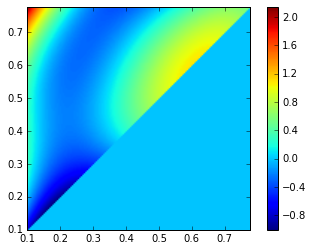

In [58]:
sizegrid=150
x=np.linspace( 0.1, np.max(T), num=sizegrid)
y=np.linspace( 0.1, np.max(T), num=sizegrid)
arr=[x,y]
Grid=expandnp(arr)
x=Grid[:,0]
y=Grid[:,1]
arrV=np.zeros(sizegrid**2,float)
n=0
for i in range(sizegrid):
    for j in range(sizegrid):
        if j<=i:
            arrV[n] = Beta_fonc_est[0](x[n],y[n])
        n+=1
Xfig=x.reshape((sizegrid,sizegrid))
Yfig=y.reshape((sizegrid,sizegrid))
Zfig=arrV.reshape((sizegrid,sizegrid))

plt.imshow(Zfig, vmin=Zfig.min(), vmax=Zfig.max(), origin='lower',
           extent=[ Yfig.min(), Yfig.max(),Xfig.min(),Xfig.max()])
plt.colorbar()
plt.show()


### Surface de la fonction paramètre réelle

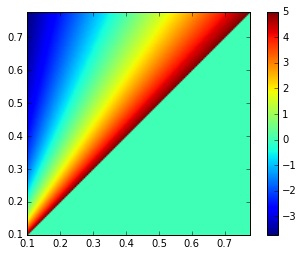

In [42]:
arrV=np.zeros(sizegrid**2,float)
n=0
for i in range(sizegrid):
    for j in range(sizegrid):
        if j<=i:
            arrV[n] = true_beta.val([x[n],y[n]])
        n+=1
Xfig=x.reshape((sizegrid,sizegrid))
Yfig=y.reshape((sizegrid,sizegrid))
Zfig=arrV.reshape((sizegrid,sizegrid))

plt.imshow(Zfig, vmin=Zfig.min(), vmax=Zfig.max(), origin='lower',
           extent=[Xfig.min(),Xfig.max(), Yfig.min(), Yfig.max()])
plt.colorbar()
plt.show()

## D) Tests pour la validation du Gradient

In [61]:
J=5
# Phi_mat
Phi= Base([Kbeta,Kbeta])
Phi_mat= Comp_Phi(Phi,T,J)

# Vérification du gradient avec scipy.optimize.approx_fprime et check_grad
print("Po")
print(Po)
print("Gradient calculé en Po")
calc=L_YlX_noC(Po,Z,L,T,Xdata,Y,Phi_mat,k,Psi,moy_est)[1]
print(calc)
Appr=sc.optimize.approx_fprime(Po, L_YlX_noC_V, 1e-7*np.ones(len(Po)), Z,L,T,Xdata,Y,Phi_mat,k,Psi,moy_est)
print("Approx du gradient en Po")
print(Appr)
print(np.sqrt((Appr-calc).dot((Appr-calc))))
A=sc.optimize.check_grad(L_YlX_noC_V,L_YlX_noC_G,Po, Z,L,T,Xdata,Y,Phi_mat,k,Psi,moy_est )
print("Cette fonction renvoie la racine de la somme des carrés des erreurs entre le gradient approximé numériquement et le gradient calculé par la deuxième entrée")
print(A)

Po
[  0.         -13.81111992 -20.43022372  21.13352733 -24.71706398]
Gradient calculé en Po
[     0.         -10408.91800605  -1958.47876813  -5830.08266576
  -1159.65492059]
Approx du gradient en Po
[     0.         -25407.31482441  -7538.10396418 -15507.84858409
  -5259.3354485 ]
19145.5127393
Cette fonction renvoie la racine de la somme des carrés des erreurs entre le gradient approximé numériquement et le gradient calculé par la deuxième entrée
19145.5160272


### Surface de la vraisemblance locale au niveau d'une section 2D passant par le point d'initialisation

Po
[  0.         -41.8114451    2.27369087  23.99531827  -1.86349058]
Grad en Po
[    0.         -4652.70487612 -1176.65527526 -2425.87588506  -666.17633461]
Approx du gradient en Po
[   0.         -487.50414862 -118.79354133 -228.11203962  -56.7814277 ]
Somme des carrés des écarts
4865.13068902


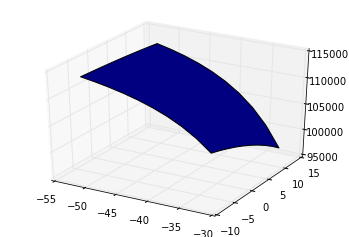

In [50]:
J=15
# Phi_mat
Phi= Base([Kbeta,Kbeta])
Phi_mat= Comp_Phi(Phi,T,J)

sizegrid=10
maxray=10.
x=np.linspace( Po[1]-maxray, Po[1]+maxray, num=sizegrid)
y=np.linspace( Po[2]-maxray, Po[2]+maxray, num=sizegrid)
arr=[x,y]
Grid=expandnp(arr)
x=Grid[:,0]
y=Grid[:,1]
print("Po")
print(Po)
V=L_YlX_noC(Po,Z,L,T,Xdata,Y,Phi_mat,k,Psi,moy_est)
print("Grad en Po")
print(V[1])
Appr=sc.optimize.approx_fprime(Po, L_YlX_noC_V, 1e-7*np.ones(len(Po)), Z,L,T,Xdata,Y,Phi_mat,k,Psi,moy_est)
print("Approx du gradient en Po")
print(Appr)
print("Somme des carrés des écarts")
print(np.sqrt((Appr-V[1]).dot((Appr-V[1]))))
arrV=np.zeros(sizegrid**2,float)
P=Po+np.zeros(len(Po))
for i in range(sizegrid**2):
    P[1]=x[i]
    P[2]=y[i]
    arrV[i]=L_YlX_noC_V(P,Z,L,T,Xdata,Y,Phi_mat,k,Psi,moy_est)

Xfig=x.reshape((sizegrid,sizegrid))
Yfig=y.reshape((sizegrid,sizegrid))
Zfig=arrV.reshape((sizegrid,sizegrid))

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Xfig, Yfig, Zfig)

# 4) Régression fonctionnelle pénalisée : $\mathcal{L}(Y|X,\mathcal{P})+\lambda Pen(\beta)$

La pénalité de $\beta$ est dérivée à partir des intégrale du carré de la courbure des fonctions $\phi_i \phi_j$ sur le domaine. On calcule donc ces intégrales avant l'optimisation pour les transmettre à la fonction L_Y|X_pen_noCens chargée de l'évaluation de la vraisemblance et du gradient.

## A) Courbure de la base

On commence tout d'abord par calculer les matrices des intégrales des produits croisés des dérivées secondes des fonction de la base $\phi_1,...,\phi_{K_{\beta}}$.

In [13]:
Kbeta=5
Tmax=np.max(T)
J=100
# symbole associé au petit t (c'est à dire l'instant dans la période de suivi)
t=sy.Symbol('t')
# smbole associé au grand T (c'est à dire la durée de suivie)
s=sy.Symbol('s')

syPhi=sy.ones(Kbeta**2,1)
v=[np.arange(Kbeta),np.arange(Kbeta)]
expo=expandnp(v)
Phi_fonc=[ [] for j in range(Kbeta**2) ]
for x in range(len(expo[:,0])):
        syPhi[x]=(t**expo[x,0])*(s**expo[x,1])
        #Phi_fonc[x]=sy.lambdify((t,s),syPhi[x],'numpy')  
sy.pprint(syPhi[:])
(Is,Ic,It)=J22_fast(syPhi,Tmax,J)
# I_pen
I_pen=Is+2*Ic+It

# On fixe l'hyperparamètre lié à la pénalité
Lambda=1.

Calcul de I_pen
75.6543722369 secondes de calcul


## B) Test

Po
[  0.           9.66292835  -1.42579648   4.39290512   3.67655259
   0.21900491  -6.32863971   2.13077613   2.08833403   2.06602772
   0.86844692   2.64028649  -0.99585784  -1.01648952  -1.092248
  -2.96139087   2.73539767  -1.7278269    4.57849289  -4.62805428
   4.4564407    6.05864948  -3.66121425  11.97598431   7.93935903
   4.2432333   -3.7332414    0.83348685  -0.1396892   -4.57680311
 -11.43643064   2.57451861  -1.71618611 -10.77789258  -4.82601383
  -3.29923773   1.04903926  -5.04775806  -7.69270084  -0.31937309
   9.74400108  -4.44162878   3.27275027  -0.4685238    3.73519665
  -1.90826204  -5.59678527   3.34717358   6.08126651   2.38092007
  -2.60338577   0.69435545  -3.80453366  -1.3582599    2.06055521
  -2.41711377  -0.30701935   5.37217895  -2.85850773   7.32723245
  -9.1511981    5.88275012  16.11798397  -3.27629892  -4.71543405
  -6.80171334  -4.6568397    6.04376267  -1.79407658   3.2155611
  -4.42495837  -4.05522604   2.61015332   7.52009374  -3.20396227
   4.81825

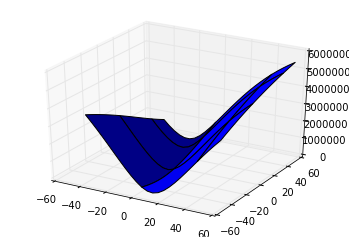

In [14]:
# Initialisation aléatoire de b (ne doit pas être à 0)
b=np.random.normal(0.,5.,D*Kbeta**2).reshape((Kbeta**2,D))

Po=np.concatenate( ( Alpha.reshape(-1), (b.T).reshape(-1)) )

J=10
# Phi_mat
Phi= Base([Kbeta,Kbeta])
Phi_mat= Comp_Phi(Phi,T,J)

sizegrid=25
maxray=50.
x=np.linspace( Po[1]-maxray, Po[1]+maxray, num=sizegrid)
y=np.linspace( Po[2]-maxray, Po[2]+maxray, num=sizegrid)
arr=[x,y]
Grid=expandnp(arr)
x=Grid[:,0]
y=Grid[:,1]
print("Po")
print(Po)
V=L_YlX_pen_noC(Po,Z,L,T,Xdata,Y,Phi_mat,k,Psi,moy_est,I_pen,Lambda)
print("Grad en Po")
print(V[1])
Appr=sc.optimize.approx_fprime(Po, L_YlX_pen_noC_V, 1e-4*np.ones(len(Po)), Z,L,T,Xdata,Y,Phi_mat,k,Psi,moy_est,I_pen,Lambda)
print("Approx du gradient en Po")
print(Appr)
print("Ecart-type")
print(np.sqrt((Appr-V[1]).dot((Appr-V[1])))/(Kbeta**2))

J=10
# Phi_mat
Phi= Base([Kbeta,Kbeta])
Phi_mat= Comp_Phi(Phi,T,J)

arrV=np.zeros(sizegrid**2,float)
P=Po+np.zeros(len(Po))
for i in range(sizegrid**2):
    P[1]=x[i]
    P[2]=y[i]
    arrV[i]=L_YlX_pen_noC_V(P,Z,L,T,Xdata,Y,Phi_mat,k,Psi,moy_est,I_pen,Lambda)

Xfig=x.reshape((sizegrid,sizegrid))
Yfig=y.reshape((sizegrid,sizegrid))
Zfig=arrV.reshape((sizegrid,sizegrid))
plt.imshow(Zfig, vmin=Zfig.min(), vmax=Zfig.max(), origin='lower',
           extent=[Xfig.min(),Xfig.max(), Yfig.min(), Yfig.max()])
plt.colorbar()
plt.show()

In [17]:
J=15
# Phi_mat
Phi= Base([Kbeta,Kbeta])
Phi_mat= Comp_Phi(Phi,T,J)

print('Vrais initiale')
print(L_YlX_pen_noC(Po,Z,L,T,Xdata,Y,Phi_mat,k,Psi,moy_est,I_pen,Lambda)[0])

opts0={'disp': True, 'maxiter': 15}
print('Résultat par BFGS')
deb=time.clock()
Res=sc.optimize.minimize(L_YlX_pen_noC,x0=Po, args= (Z,L,T,Xdata,Y,Phi_mat,k,Psi,moy_est,I_pen,Lambda) ,jac=True, method='BFGS',options=opts0)
b_learned=Res.x[p:(p+D*Kbeta**2)]
b_learned=(b_learned).reshape((D,Kbeta**2)).T
print(str(time.clock()-deb)+" secondes")
print("Current function value : "+str(Res.fun))
print("Jacobian : "+str(Res.jac))
print("Message : "+str(Res.message))
print("iterations : "+str(+Res.nit))
print('b_learned')
print(b_learned)

Vrais initiale
769421.375222
Résultat par BFGS
         Current function value: -658225108.191564
         Iterations: 7
         Function evaluations: 43
         Gradient evaluations: 31
39.2753370688 secondes
Current function value : -658225108.192
Jacobian : [     0.          86137.23491543  71662.80095344  54230.04470615
  36336.86977405  18356.94794245    414.54155045 -17436.23701102
 -35167.86850503 -52764.92794034 -70218.21435948  30381.16275447
  22500.53390253  15958.98809038  10185.75927669   4872.56098789
   -137.67822188  -4932.42654377  -9564.27612377 -14066.80694073
 -18462.51144465  12897.99770964  12373.60452007  11421.23619796
  10385.32868752   9326.52004055   8263.4053451    7203.22143329
   6149.19430035   5102.90358936   4065.17489882  11098.58684986
  11509.43590824  11625.50092185  11673.9389427   11697.42507191
  11709.60546026  11715.93661265  11718.91466547  11719.80459625
  11719.30169477   9798.78829281  10548.64524489  11082.40409882
  11560.86289917  1201